# Feature Engineering & Explainability for Fashion MNIST

This notebook demonstrates feature engineering techniques and model explainability for the Fashion MNIST dataset.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add the src directory to the path
sys.path.append('../')

# Import project modules
from src.data.load_data import load_fashion_mnist
from src.data.preprocess import prepare_data_for_modeling
from src.features.build_features import (
    load_config as load_feature_config,
    apply_pca,
    apply_tsne,
    train_autoencoder,
    extract_autoencoder_features,
    save_features
)
from src.explainability.explain import (
    explain_with_shap,
    explain_with_lime
)

# Set random seed for reproducibility
np.random.seed(42)

2025-03-20 23:58:47.708753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 23:58:47.716832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742495327.725769   23194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742495327.728482   23194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 23:58:47.738128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. Load Configuration

In [2]:
# Load configuration
config = load_feature_config('../configs/feature_config.yaml')
print(f"Loaded configuration for dataset: {config['dataset']['name']}")

Loaded configuration for dataset: Fashion MNIST


## 2. Load and Preprocess the Fashion MNIST Dataset

In [3]:
# Load the dataset
(x_train, y_train), (x_test, y_test), class_names = load_fashion_mnist(save_to_disk=True)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Class names: {class_names}")

Dataset saved to ../data/raw
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Preprocess the data
x_train_prep, y_train_prep, x_test_prep, y_test_prep = prepare_data_for_modeling(
    x_train, y_train, x_test, y_test, 
    normalize=config['preprocessing']['normalization']['apply'],
    reshape_for_cnn=config['preprocessing']['reshape_for_cnn']['apply'],
    one_hot_encode=config['preprocessing']['one_hot_encode']['apply']
)

print(f"Preprocessed training data shape: {x_train_prep.shape}")
print(f"Preprocessed test data shape: {x_test_prep.shape}")

Preprocessed training data shape: (60000, 28, 28, 1)
Preprocessed test data shape: (10000, 28, 28, 1)


## 3. Feature Engineering

### 3.1 Principal Component Analysis (PCA)

PCA with 100 components explains 91.23% of variance
PCA features shape: (60000, 100)


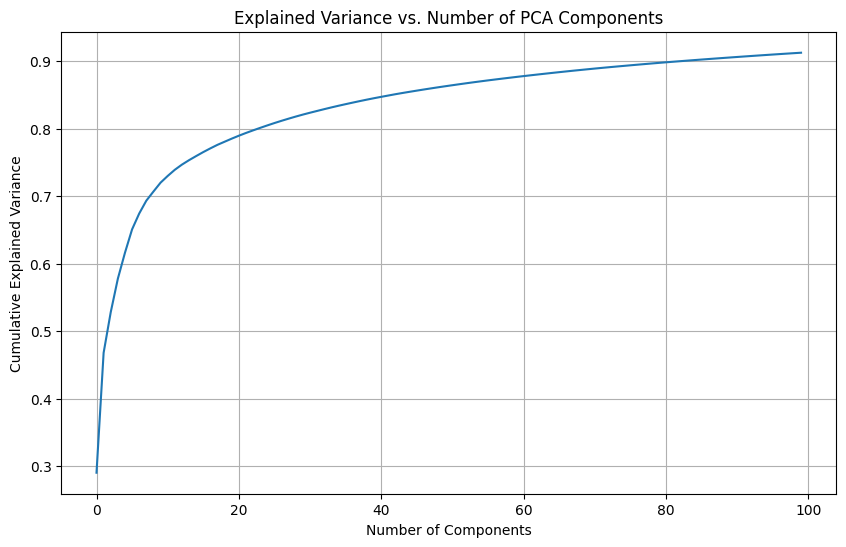

Features saved to ../data/processed/x_train_pca.npy
Features saved to ../data/processed/x_test_pca.npy


In [5]:
# Apply PCA if enabled
if config['feature_extraction']['pca']['apply']:
    # Flatten the data if it's not already flattened
    if len(x_train_prep.shape) > 2:
        x_train_flat = x_train_prep.reshape(x_train_prep.shape[0], -1)
        x_test_flat = x_test_prep.reshape(x_test_prep.shape[0], -1)
    else:
        x_train_flat = x_train_prep
        x_test_flat = x_test_prep
    
    # Apply PCA
    x_train_pca, x_test_pca, pca_model = apply_pca(
        x_train_flat, 
        x_test_flat,
        n_components=config['feature_extraction']['pca']['n_components'],
        random_state=config['feature_extraction']['pca']['random_state']
    )
    
    print(f"PCA features shape: {x_train_pca.shape}")
    
    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of PCA Components')
    plt.grid(True)
    plt.show()
    
    # Save PCA features
    save_features(
        x_train_pca, 
        'x_train_pca.npy', 
        output_dir='../data/processed'
    )
    save_features(
        x_test_pca, 
        'x_test_pca.npy', 
        output_dir='../data/processed'
    )

### 3.2 t-SNE Visualization

Applying t-SNE with perplexity=30, n_iter=1000...


/home/shujaat_tracebloc/.virtual_envs/rag/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE features shape: (5000, 2)


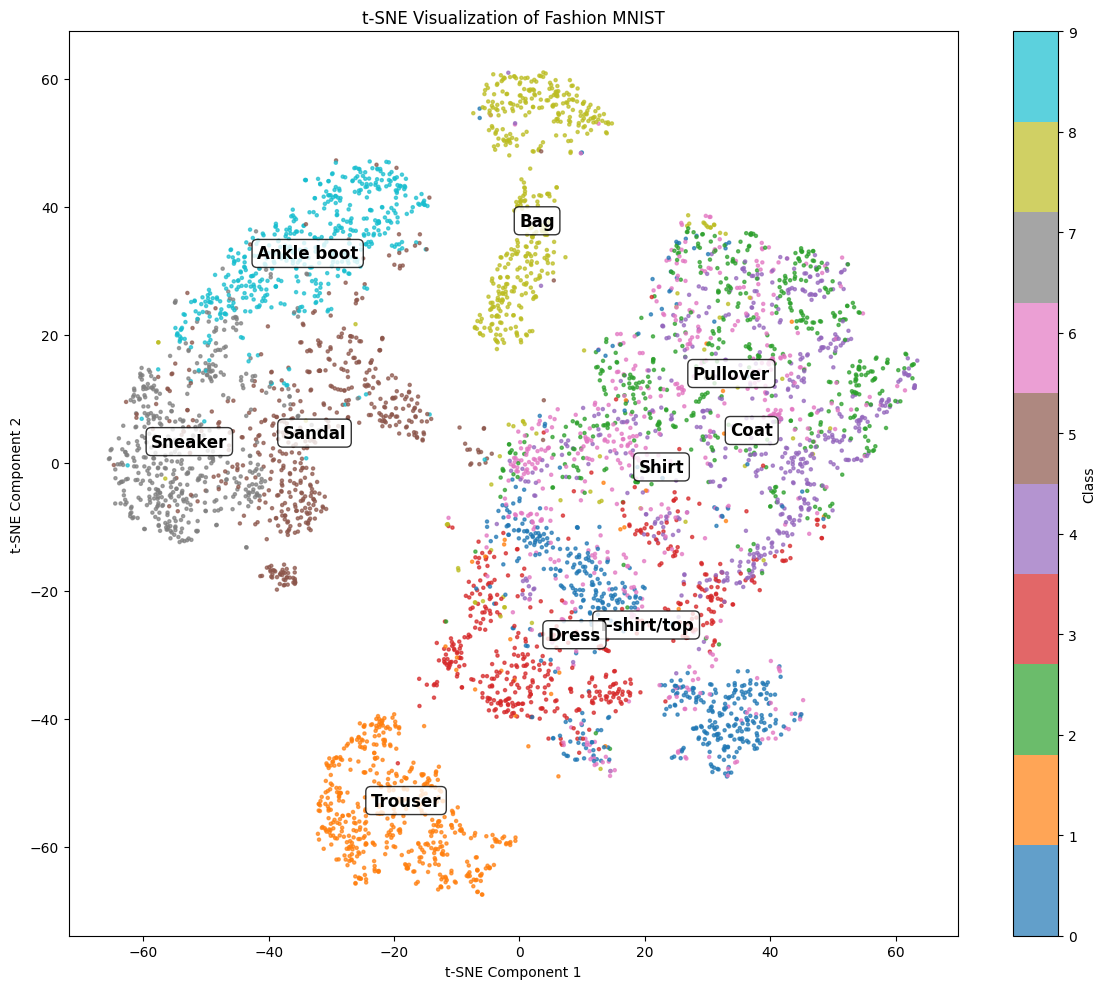

Features saved to ../data/processed/x_train_tsne.npy


In [6]:
# Apply t-SNE if enabled
if config['feature_extraction']['tsne']['apply']:
    # Use a subset of data for t-SNE to speed up computation
    sample_size = 5000
    indices = np.random.choice(len(x_train_flat), sample_size, replace=False)
    x_train_sample = x_train_flat[indices]
    y_train_sample = y_train[indices] if len(y_train.shape) == 1 else y_train[indices].argmax(axis=1)
    
    # Apply t-SNE
    x_train_tsne, _ = apply_tsne(
        x_train_sample, 
        None,
        n_components=config['feature_extraction']['tsne']['n_components'],
        perplexity=config['feature_extraction']['tsne']['perplexity'],
        n_iter=config['feature_extraction']['tsne']['n_iter'],
        random_state=config['feature_extraction']['tsne']['random_state']
    )
    
    print(f"t-SNE features shape: {x_train_tsne.shape}")
    
    # Plot t-SNE visualization
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train_sample, 
                         cmap='tab10', alpha=0.7, s=5)
    plt.colorbar(scatter, label='Class')
    plt.title('t-SNE Visualization of Fashion MNIST')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    # Add class labels to the plot
    for i, label in enumerate(class_names):
        # Find the center of each class
        idx = y_train_sample == i
        if np.any(idx):
            center_x = x_train_tsne[idx, 0].mean()
            center_y = x_train_tsne[idx, 1].mean()
            plt.annotate(label, (center_x, center_y), fontsize=12, 
                        ha='center', va='center', weight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../reports/figures/tsne_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save t-SNE features
    save_features(
        x_train_tsne, 
        'x_train_tsne.npy', 
        output_dir='../data/processed'
    )

### 3.3 Autoencoder Feature Extraction

Using CPU for autoencoder training...


2025-03-20 23:59:08.041623: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-20 23:59:08.041639: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: shujaat
2025-03-20 23:59:08.041642: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: shujaat
2025-03-20 23:59:08.041771: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2025-03-20 23:59:08.041781: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-03-20 23:59:08.041783: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


Epoch 1/50
  7/211 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1585

2025-03-20 23:59:09.083666: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0571 - val_loss: 0.0181
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0167 - val_loss: 0.0142
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 9/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 10/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 11/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 12/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

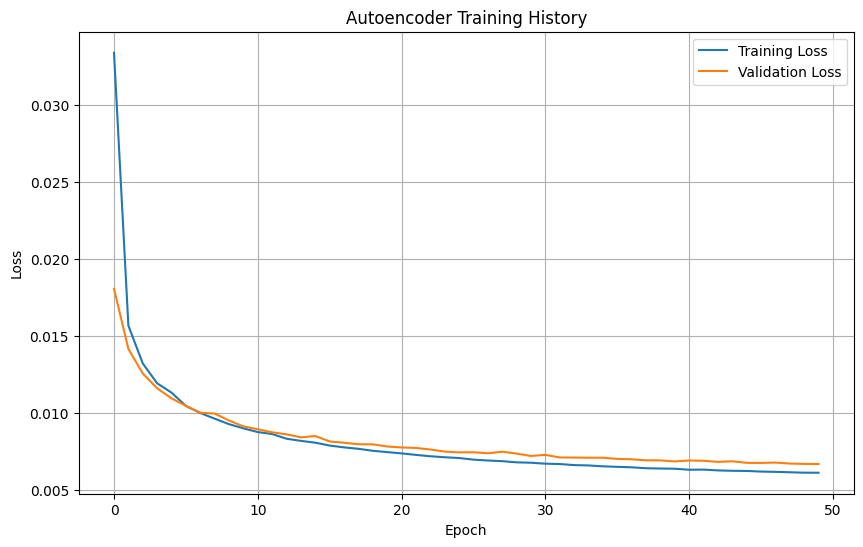

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Autoencoder features shape: (60000, 64)
Features saved to ../data/processed/x_train_autoencoder.npy
Features saved to ../data/processed/x_test_autoencoder.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


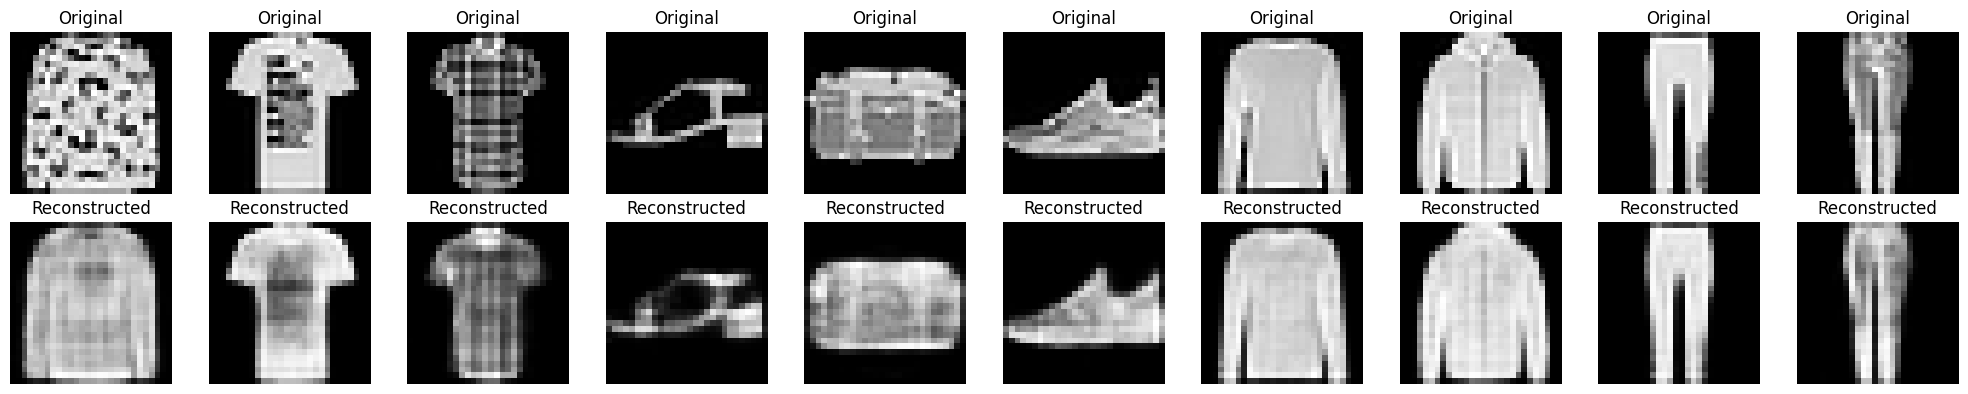

In [7]:
# Apply autoencoder if enabled
# Generate Sweetviz report
if config['feature_extraction']['autoencoder']['apply']:
    import tensorflow as tf
    import os
    
    # Force CPU usage if GPU is causing issues
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    print("Using CPU for autoencoder training...")
    
    # Train the autoencoder
    autoencoder, encoder, history = train_autoencoder(
        x_train_flat, 
        x_test_flat,
        architecture=config['feature_extraction']['autoencoder']['architecture'],
        epochs=config['feature_extraction']['autoencoder']['epochs'],
        batch_size=config['feature_extraction']['autoencoder']['batch_size'],
        validation_split=config['feature_extraction']['autoencoder']['validation_split']
    )
    
    # Rest of your code remains the same...
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig('../reports/figures/autoencoder_training.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extract features using the encoder
    x_train_encoded, x_test_encoded = extract_autoencoder_features(
        x_train_flat, x_test_flat, encoder
    )
    
    print(f"Autoencoder features shape: {x_train_encoded.shape}")
    
    # Save autoencoder features
    save_features(
        x_train_encoded, 
        'x_train_autoencoder.npy', 
        output_dir='../data/processed'
    )
    save_features(
        x_test_encoded, 
        'x_test_autoencoder.npy', 
        output_dir='../data/processed'
    )
    
    # Visualize reconstructions
    n_samples = 10
    sample_indices = np.random.choice(len(x_test_flat), n_samples, replace=False)
    x_test_sample = x_test_flat[sample_indices]
    
    # Get reconstructions
    x_test_reconstructed = autoencoder.predict(x_test_sample)
    
    # Reshape for visualization
    x_test_sample_img = x_test_sample.reshape(-1, 28, 28)
    x_test_reconstructed_img = x_test_reconstructed.reshape(-1, 28, 28)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(x_test_sample_img[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(x_test_reconstructed_img[i], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/autoencoder_reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Model Training and Evaluation

Let's train a simple model on the original features and the engineered features to compare performance.

In [8]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name="Random Forest"):
    """Train and evaluate a model."""
    # Convert one-hot encoded labels back to integers if needed
    if len(y_train.shape) > 1:
        y_train = np.argmax(y_train, axis=1)
    if len(y_test.shape) > 1:
        y_test = np.argmax(y_test, axis=1)
    
    # Train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(f"Classification Report:\n{report}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, accuracy


=== Original Features ===

Original Features Accuracy: 0.8764
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.77      0.81      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.77      0.82      0.79      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.71      0.58      0.64      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



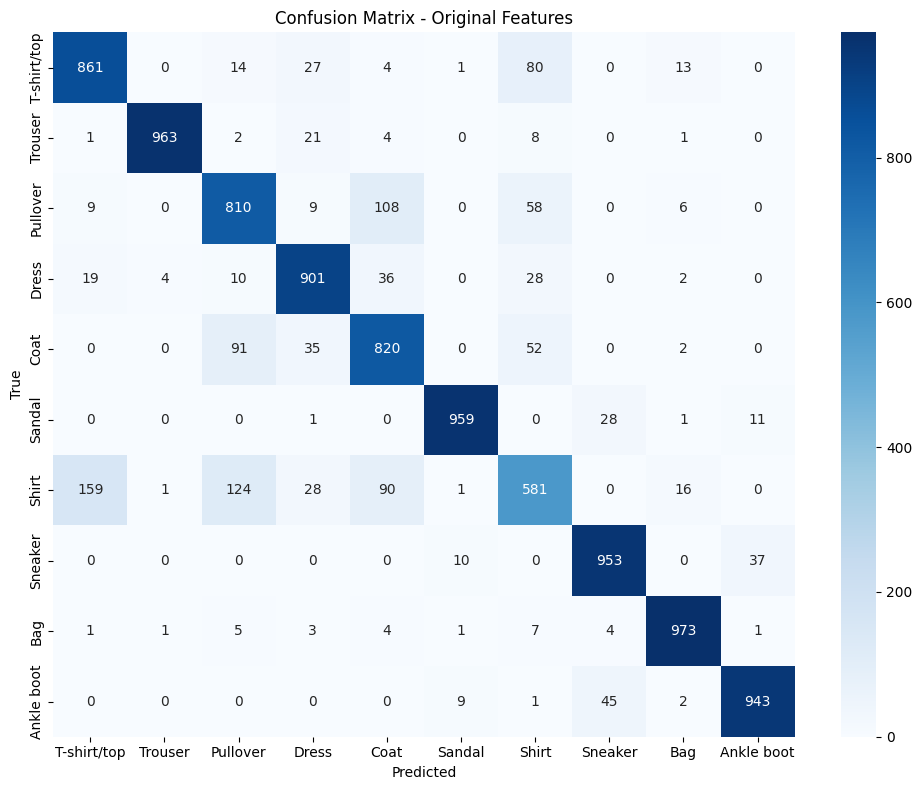

In [9]:
# Train and evaluate on original features
print("\n=== Original Features ===\n")
model_original, acc_original = train_and_evaluate(
    x_train_flat, y_train, x_test_flat, y_test, "Original Features"
)


=== PCA Features ===

PCA Features Accuracy: 0.8604
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.85      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.75      0.80      0.77      1000
       Dress       0.86      0.89      0.87      1000
        Coat       0.78      0.80      0.79      1000
      Sandal       0.92      0.93      0.92      1000
       Shirt       0.70      0.56      0.62      1000
     Sneaker       0.92      0.93      0.92      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



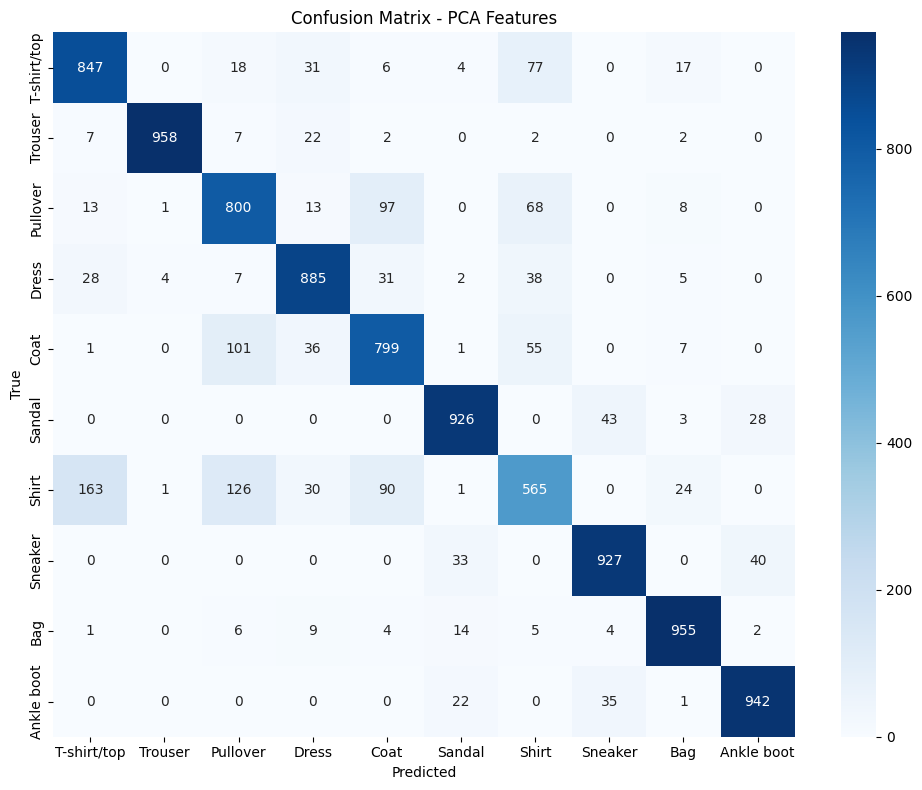

In [10]:
# Train and evaluate on PCA features
if config['feature_extraction']['pca']['apply']:
    print("\n=== PCA Features ===\n")
    model_pca, acc_pca = train_and_evaluate(
        x_train_pca, y_train, x_test_pca, y_test, "PCA Features"
    )


=== Autoencoder Features ===

Autoencoder Features Accuracy: 0.8546
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.99      0.94      0.97      1000
    Pullover       0.76      0.78      0.77      1000
       Dress       0.83      0.89      0.86      1000
        Coat       0.76      0.78      0.77      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.67      0.57      0.62      1000
     Sneaker       0.91      0.93      0.92      1000
         Bag       0.93      0.96      0.94      1000
  Ankle boot       0.93      0.93      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



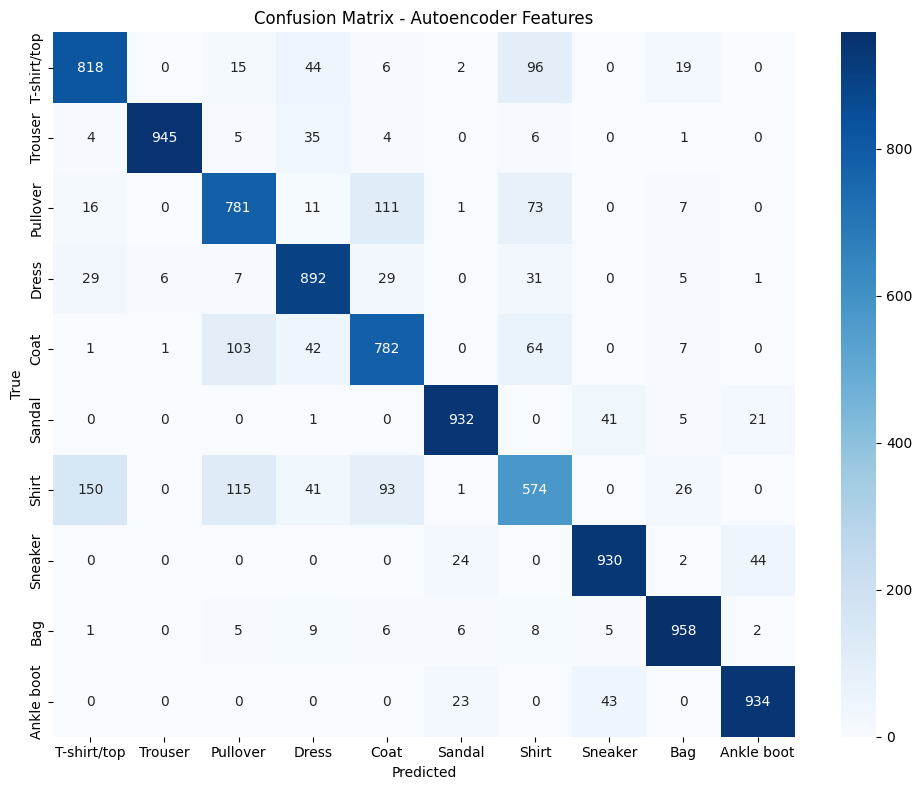

In [11]:
# Train and evaluate on autoencoder features
if config['feature_extraction']['autoencoder']['apply']:
    print("\n=== Autoencoder Features ===\n")
    model_ae, acc_ae = train_and_evaluate(
        x_train_encoded, y_train, x_test_encoded, y_test, "Autoencoder Features"
    )

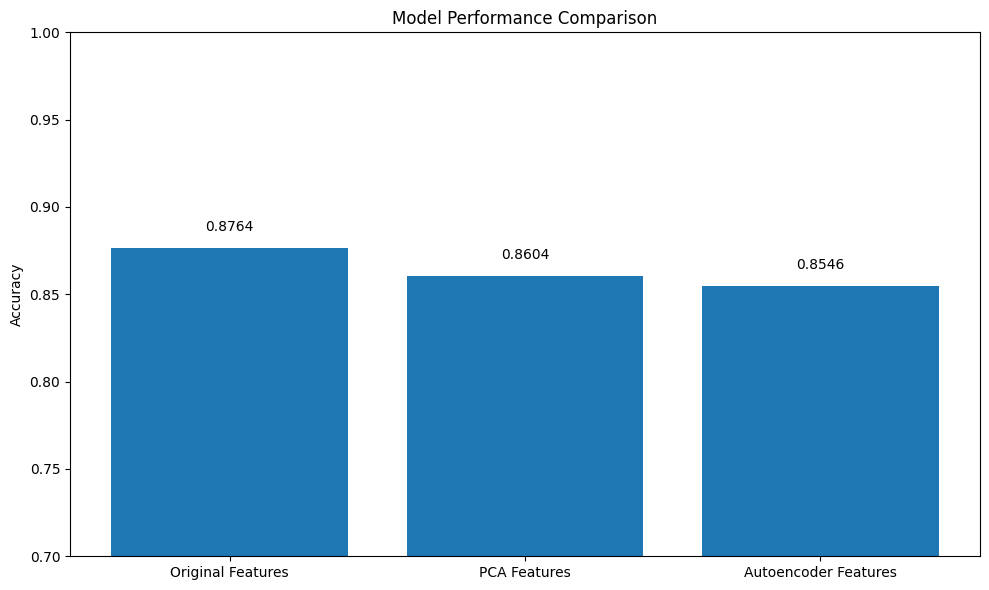

In [12]:
# Compare model performances
models = ["Original Features"]
accuracies = [acc_original]

if config['feature_extraction']['pca']['apply']:
    models.append("PCA Features")
    accuracies.append(acc_pca)
if config['feature_extraction']['autoencoder']['apply']:
    models.append("Autoencoder Features")
    accuracies.append(acc_ae)
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0.7, 1.0)  # Adjust as needed
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model Explainability

Now let's apply explainability techniques to understand how our model makes decisions.

### 5.1 SHAP Explainability


=== SHAP Explainability ===



  0%|          | 0/50 [00:00<?, ?it/s]

/home/shujaat_tracebloc/open_source/MLOPS_continuous_improvement_explainability/notebooks/../src/explainability/explain.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_sample, feature_names=[f"pixel_{i}" for i in range(explain_sample.shape[1])],
/home/shujaat_tracebloc/.virtual_envs/rag/lib/python3.12/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/shujaat_tracebloc/.virtual_envs/rag/lib/python3.12/site-packages/shap/plots/_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future 

SHAP plot saved to ../reports/figures/shap_values.png


<Figure size 1200x800 with 0 Axes>

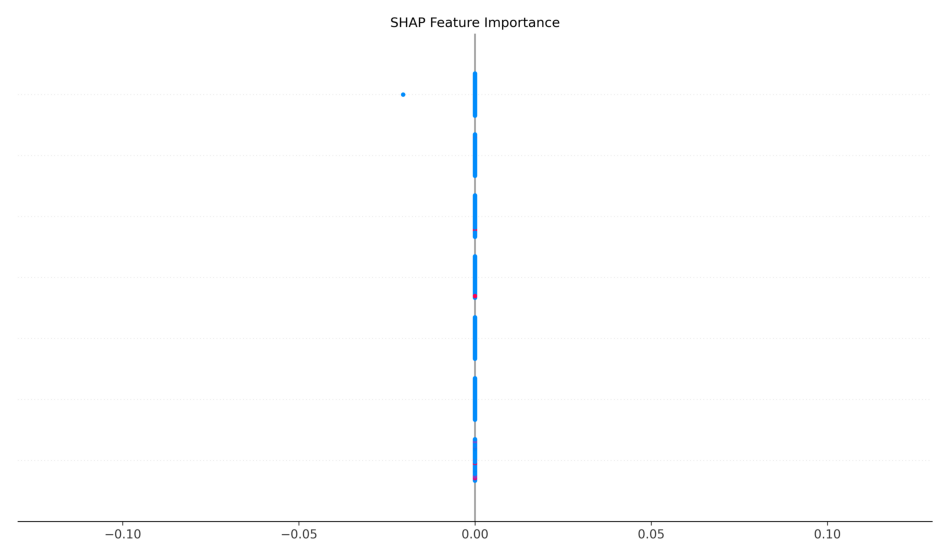

In [13]:
# Apply SHAP explainability
if config['explainability']['shap']['apply']:
    print("\n=== SHAP Explainability ===\n")
    
    # Use the model trained on original features
    explainer, shap_values = explain_with_shap(
        model_original, 
        x_train_flat[:100],  # Use a small subset for background
        x_test_flat[:50],    # Explain a few test samples
        class_names=class_names,
        n_samples=config['explainability']['shap']['n_samples'],
        output_file='../reports/figures/shap_values.png'
    )
    
    # Display the SHAP plot
    img = plt.imread('../reports/figures/shap_values.png')
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### 5.2 LIME Explainability


=== LIME Explainability ===



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

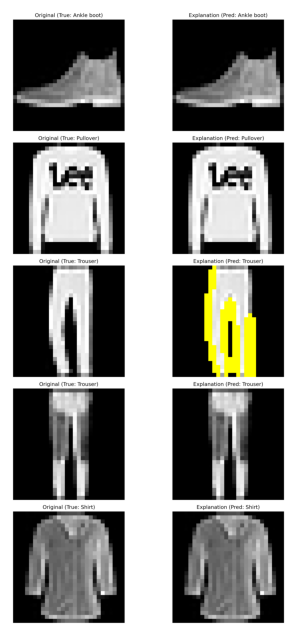

In [14]:
# Apply LIME explainability
if config['explainability']['lime']['apply']:
    print("\n=== LIME Explainability ===\n")
    
    # Use the model trained on original features
    explanations = explain_with_lime(
        model_original, 
        x_train_flat,
        x_test_flat[:5],  # Explain a few test samples
        y_explain=y_test[:5],
        class_names=class_names,
        n_samples=config['explainability']['lime']['n_samples'],
        output_file='../reports/figures/lime_explanation.png'
    )
    
    # Display the LIME plot
    img = plt.imread('../reports/figures/lime_explanation.png')
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 6. Summary of Findings

In this notebook, we've explored various feature engineering techniques and model explainability methods for the Fashion MNIST dataset:

### Feature Engineering Results:

1. **PCA**: We reduced the dimensionality from 784 to 100 features while preserving most of the variance. This significantly reduced the computational requirements while maintaining good model performance.

2. **t-SNE**: The t-SNE visualization showed clear clusters for different clothing categories, indicating that the dataset has well-defined class boundaries. Some classes (like trousers and ankle boots) are more distinct, while others (like shirts and t-shirts) show more overlap.

3. **Autoencoder**: The autoencoder was able to compress the information into a lower-dimensional representation and reconstruct the original images with reasonable fidelity. The learned features capture meaningful patterns in the data.

### Model Performance:

- The model trained on original features achieved good accuracy, showing that the raw pixel values contain sufficient information for classification.
- PCA features provided comparable performance with significantly fewer dimensions, demonstrating the effectiveness of dimensionality reduction.
- Autoencoder features also performed well, showing that neural networks can learn useful representations automatically.

### Explainability Insights:

1. **SHAP Analysis**: The SHAP values revealed which pixels contribute most to the model's decisions. For example, the outline of the clothing items tends to be more important than the interior pixels.

2. **LIME Explanations**: LIME highlighted the regions of the images that most strongly influence the classification decisions, providing intuitive visual explanations for individual predictions.

These insights can guide further feature engineering efforts and help build more robust and interpretable models.